<img src="./images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

# Qiskit Aer: Simulators

The latest version of this notebook is available on https://github.com/Qiskit/qiskit-tutorial.

**NOTE: THIS ONLY WORKS ON QISKIT-TERRA 0.7, QISKIT-AER 0.1**

***
### Contributors
Christopher J. Wood$^{1}$

1. IBM T.J. Watson Research Center, Yorktown Heights, NY, USA

## Introduction

This notebook shows how to import *Qiskit Aer* simulators backends and use them to execut ideal (noise free) Qiskit Terra circuits.

In [1]:
import numpy as np

# Import Qiskit
from qiskit_aer import Aer
from qiskit import execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.tools.visualization import plot_histogram, plot_state_city

## Qiskit Aer simulator backends

Currently Qiskit Aer currently includes three high performance simulator backends:
* `QasmSimulator`: Allows ideal and noisy multi-shot execution of qiskit circuits and returns counts or memory
* `StatevectorSimulator`: Allows ideal single-shot execution of qiskit circuits and returns the final statevector of the simulator after application
* `UnitarySimulator`: Allows ideal single-shot execution of qiskit circuits and returns the final unitary matrix of the circuit itself. Note that the circuit cannot contain measure or reset operations for this backend

These backends are found in the `Aer` provider with the names `qasm_simulstor`, `statevector_simulator` and `unitary_simulator` respectively

In [2]:
from qiskit_aer import Aer

# List Aer backends
Aer.backends()

[<QasmSimulator('qasm_simulator') from AerProvider()>,
 <StatevectorSimulator('statevector_simulator') from AerProvider()>,
 <UnitarySimulator('unitary_simulator') from AerProvider()>]

The backends can also be directly imported from the `qiskit_aer.backends` without using the provider

In [3]:
from qiskit_aer.backends import QasmSimulator, StatevectorSimulator, UnitarySimulator

## QasmSimulator

The `QasmSimulator` backend is designed to mimic an actual device. It executes a Qiskit `QuantumCircuit` and returns a count dictionary containing the final values of any classical registers in the circuit. The circuit may contain *gates*
*measure*, *reset*, *conditionals*, and other advanced simulator options that will be discussed in another notebook.

### Simulating a quantum circuit

The basic operation executes a quantum circuit and returns a counts dictionary of measurement outcomes. We consider executing a simple circuit that repares a 2-qubit Bell-state $|\psi\rangle = \frac{1}{2}(|0,0\rangle + |1,1 \rangle)$ and measures both qubits.

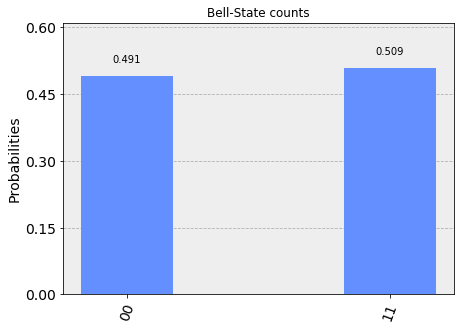

In [4]:
# Construct quantum circuit
qr = QuantumRegister(2, 'qr')
cr = ClassicalRegister(2, 'cr')
circ = QuantumCircuit(qr, cr)
circ.h(qr[0])
circ.cx(qr[0], qr[1])
circ.measure(qr, cr)

# Select the QasmSimulator from the Aer provider
simulator = Aer.get_backend('qasm_simulator')

# Execute and get counts
result = execute(circ, simulator).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='Bell-State counts')

### Returning measurements outcomes for each shot

The `QasmSimulator` also supports returning a list of measurement outcomes for each individual shot. This is enabled by setting the key-word argument `memory=True` in the `compile` or `execute` function.

In [5]:
# Construct quantum circuit
qr = QuantumRegister(2, 'qr')
cr = ClassicalRegister(2, 'cr')
circ = QuantumCircuit(qr, cr)
circ.h(qr[0])
circ.cx(qr[0], qr[1])
circ.measure(qr, cr)

# Select the QasmSimulator from the Aer provider
simulator = Aer.get_backend('qasm_simulator')

# Execute and get memory
result = execute(circ, simulator, shots=10, memory=True).result()
memory = result.get_memory(circ)
print(memory)

['00', '00', '00', '00', '11', '00', '00', '00', '00', '11']


### Starting simulation with a custom initial state

The `QasmSimulator` allows setting a custom initial statevector for the simulation. This means that all experiments in a Qobj will be executed starting in a state $|\psi\rangle$ rather than the all zero state $|0,0,..0\rangle$. The custom state may be set using the `backend_options` key-word arg for `execute`, or the Aer backend `run` method.

**Note:**
* The initial statevector must be a valid quantum state $|\langle\psi|\psi\rangle|=1$. If not an exception will be raised. 
* If a Qobj contains multiple circuits, the initial statevector must be the correct size fo *all* experiments in the Qobj, otherwise an exception will be raised.

We now demonstate this functionality be executing an empty circuit, but setting the simulator to be initialized in the the final Bell-state of the previous example:

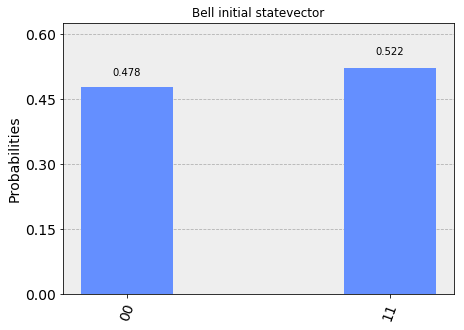

In [6]:
# Construct an empty quantum circuit
qr = QuantumRegister(2)
cr = ClassicalRegister(2)
circ = QuantumCircuit(qr, cr)
circ.measure(qr, cr)

# Set the initial state
opts = {"initial_statevector": np.array([1, 0, 0, 1] / np.sqrt(2))}

# Select the QasmSimulator from the Aer provider
simulator = Aer.get_backend('qasm_simulator')

# Execute and get counts
result = execute(circ, simulator, backend_options=opts).result()
counts = result.get_counts(circ)
plot_histogram(counts, title="Bell initial statevector")

## StatevectorSimulator


The `StatevectorSimulator` executes a single shot of a Qiskit `QuantumCircuit` and returns the final quantum statevector of the simulation.  The circuit may contain *gates*, and also *measure*, *reset*, and *conditionals*.

### Simulating a quantum circuit

The basic operation executes a quantum circuit and returns a counts dictionary of measurement outcomes. We consider executing a simple circuit that repares a 2-qubit Bell-state $|\psi\rangle = \frac{1}{2}(|0,0\rangle + |1,1 \rangle)$ and measures both qubits.

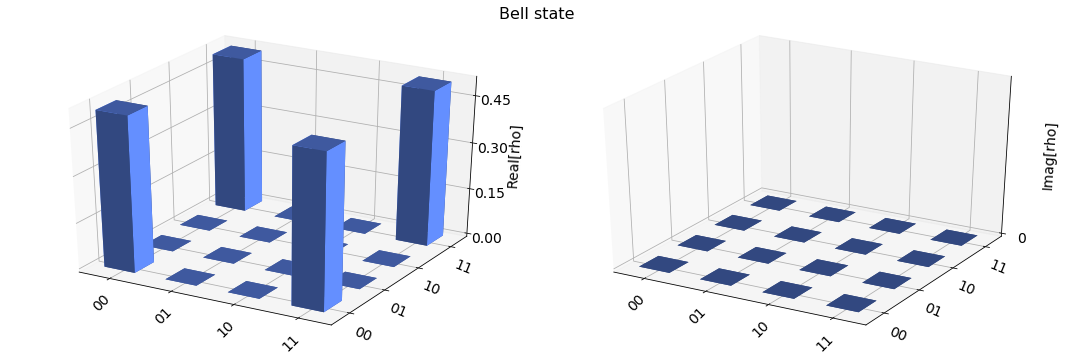

In [7]:
# Construct quantum circuit without measure
qr = QuantumRegister(2, 'qr')
circ = QuantumCircuit(qr)
circ.h(qr[0])
circ.cx(qr[0], qr[1])

# Select the StatevectorSimulator from the Aer provider
simulator = Aer.get_backend('statevector_simulator')

# Execute and get counts
result = execute(circ, simulator).result()
statevector = result.get_statevector(circ)
plot_state_city(statevector, title='Bell state')

### Simulating a quantum circuit with measurement

Note that if a circuit contains *measure*, *reset*, the final statevector will be a conditional statevector *after* simulating wave-function collapse to the outcome of a measure or reset. For the Bell-state circuit this means the final statevector will be *either* $|0,0\rangle$ *or* $|1, 1\rangle$.

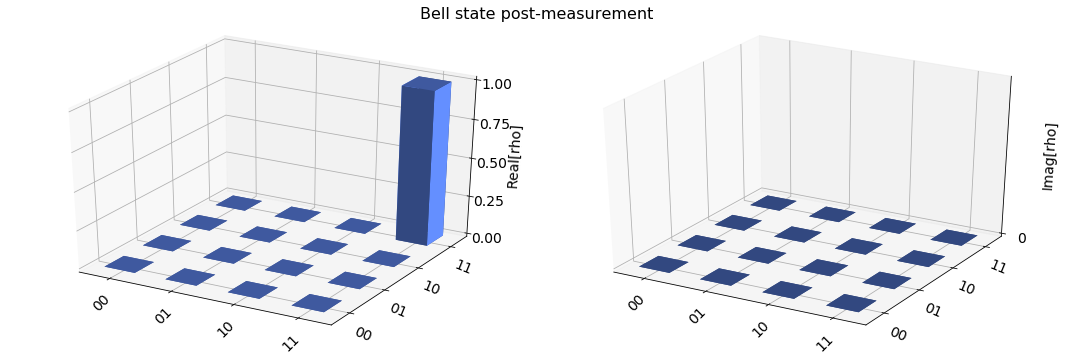

In [8]:
# Construct quantum circuit with measure
qr = QuantumRegister(2, 'qr')
cr = ClassicalRegister(2, 'cr')
circ = QuantumCircuit(qr, cr)
circ.h(qr[0])
circ.cx(qr[0], qr[1])
circ.measure(qr, cr)

# Select the StatevectorSimulator from the Aer provider
simulator = Aer.get_backend('statevector_simulator')

# Execute and get counts
result = execute(circ, simulator).result()
statevector = result.get_statevector(circ)
plot_state_city(statevector, title='Bell state post-measurement')

### Starting simulation with a custom initial state

Like the `QasmSimulator`, the `StatevectorSimulator` also allows setting a custom initial statevector for the simulation. Here we run the previous initial statevector example on the `StatevectorSimulator` to initialize it to the Bell state and execute an empty (identity) circuit.


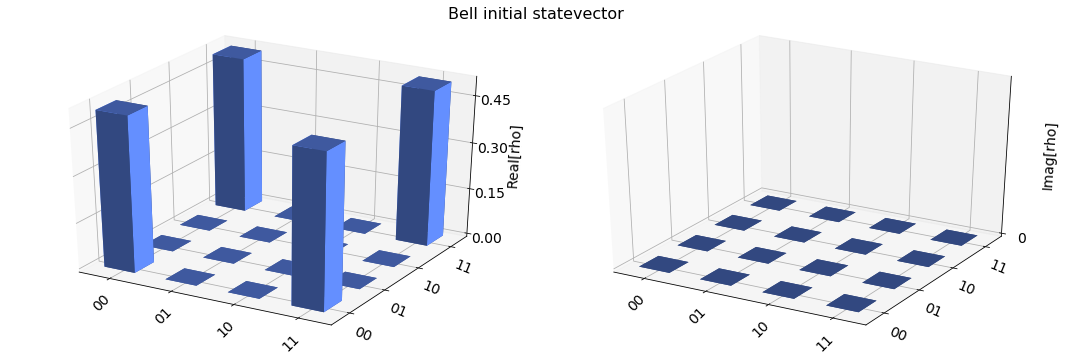

In [9]:
# Construct an empty quantum circuit
qr = QuantumRegister(2)
circ = QuantumCircuit(qr)
circ.iden(qr)

# Set the initial state
opts = {"initial_statevector": np.array([1, 0, 0, 1] / np.sqrt(2))}

# Select the StatevectorSimulator from the Aer provider
simulator = Aer.get_backend('statevector_simulator')

# Execute and get counts
result = execute(circ, simulator, backend_options=opts).result()
statevector = result.get_statevector(circ)
plot_state_city(statevector, title="Bell initial statevector")

## Unitary Simulator

The `UnitarySimulator` constructs the unitary matrix for a Qiskit `QuantumCircuit` by applying each gate matrix to an identity matrix. The circuit may only contain *gates*, if it contains *resets* or *measure* operations an exception will be raised.

### Simulating a quantum circuit unitary

For this example we will return the unitary matrix corresponding to the previous examples circuit which prepares a bell state.

In [10]:
# Construct an empty quantum circuit
qr = QuantumRegister(2)
circ = QuantumCircuit(qr)
circ.h(qr[0])
circ.cx(qr[0], qr[1])

# Select the UnitarySimulator from the Aer provider
simulator = Aer.get_backend('unitary_simulator')

# Execute and get counts
result = execute(circ, simulator).result()
unitary = result.get_unitary(circ)
print("Circuit unitary:\n", unitary)

Circuit unitary:
 [[ 0.70710678+0.j  0.70710678+0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.70710678+0.j -0.70710678+0.j]
 [ 0.        +0.j  0.        +0.j  0.70710678+0.j  0.70710678+0.j]
 [ 0.70710678+0.j -0.70710678+0.j  0.        +0.j  0.        +0.j]]


### Setting a custom initial unitary

we may also set an initial state for the `UnitarySimulator`, however this state is an initial *unitary matrix* $U_i$, not a statevector. In this case the return unitary will be $U.U_i$ given by applying the circuit unitary to the initial unitary matrix.

**Note:**
* The initial unitary must be a valid unitary matrix $U^\dagger.U =\mathbb{1}$. If not an exception will be raised. 
* If a Qobj contains multiple experiments, the initial unitary must be the correct size fo *all* experiments in the Qobj, otherwise an exception will be raised.

Let us consider preparing the output unitary of the previous circuit as the initial state for the simulator:

In [11]:
# Construct an empty quantum circuit
qr = QuantumRegister(2)
circ = QuantumCircuit(qr)
circ.iden(qr)

# Set the initial unitary
opts = {"initial_unitary": np.array([[ 1,  1,  0,  0],
                                     [ 0,  0,  1, -1],
                                     [ 0,  0,  1,  1],
                                     [ 1, -1,  0,  0]] / np.sqrt(2))}

# Select the UnitarySimulator from the Aer provider
simulator = Aer.get_backend('unitary_simulator')

# Execute and get counts
result = execute(circ, simulator, backend_options=opts).result()
unitary = result.get_unitary(circ)
unitary = result.get_unitary(circ)
print("Initial Unitary:\n", unitary)

Initial Unitary:
 [[ 0.70710678+0.j  0.70710678+0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.70710678+0.j -0.70710678+0.j]
 [ 0.        +0.j  0.        +0.j  0.70710678+0.j  0.70710678+0.j]
 [ 0.70710678+0.j -0.70710678+0.j  0.        +0.j  0.        +0.j]]
